In [1]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
conn = wrds.Connection(wrds_username='suyogmahale')


Loading library list...
Done


In [ ]:
def download_compustat_data(conn, start_year=2010, end_year=2025):
    """
    Pull quarterly accounting items from Compustat Fundamentals Quarterly (comp.fundq),
    filtered to industrial firms with standard consolidated data.

    We then standardize column names to match the rest of our pipeline:
      revtq -> revt
      cogsq -> cogs
      atq   -> at

    We also compute gross profitability gp_at = (revt - cogs) / at.
    """

    requested_cols = [
        "gvkey",
        "datadate",
        "fyearq",
        "fqtr",
        "indfmt",
        "datafmt",
        "consol",
        "popsrc",
        "revtq",    # quarterly revenue
        "cogsq",    # quarterly cogs
        "atq"      # total assets 
    ]

    df = conn.get_table(library="comp", table="fundq", columns=requested_cols)

    df["datadate"] = pd.to_datetime(df["datadate"], errors="coerce")

    df = df[
        (df["fyearq"] >= start_year) &
        (df["fyearq"] <= end_year) &
        (df["indfmt"] == "INDL") &
        (df["datafmt"] == "STD") &
        (df["consol"] == "C") &
        (df["popsrc"] == "D")
    ].copy()

    rename_map = {}
    if "revtq" in df.columns:
        rename_map["revtq"] = "revt"
    if "cogsq" in df.columns:
        rename_map["cogsq"] = "cogs"
    if "atq" in df.columns:
        rename_map["atq"] = "at"

    df = df.rename(columns=rename_map)

    for col in ["revt", "cogs", "at"]:
        if col not in df.columns:
            df[col] = np.nan

    df["gp_at"] = (df["revt"] - df["cogs"]) / df["at"]

    df = df.dropna(subset=["gvkey", "datadate", "revt", "cogs", "at"], how="any").copy()
    df = df[df["at"] > 0]  

    df = df[[
        "gvkey",
        "datadate",
        "fyearq",
        "fqtr",
        "revt",
        "cogs",
        "at",
        "gp_at"
    ]].reset_index(drop=True)

    print(f"✅ Pulled {len(df):,} quarterly rows from comp.fundq ({start_year}-{end_year}).")
    return df


compustat_raw = download_compustat_data(
    conn,
    start_year=2020,   
    end_year=2025     
)

✅ Pulled 152,732 quarterly rows from comp.fundq (2020-2025).


In [ ]:
def download_ccm_link(conn):
    """
    Pull CRSP–Compustat link table. This maps Compustat gvkey to CRSP permno.
    Keep only primary links (linkprim in 'P','C') and standard link types ('LU','LC').
    """

    cols = [
        "gvkey",
        "lpermno",      
        "linktype",
        "linkprim",
        "linkdt",      
        "linkenddt"    
    ]

    ccm = conn.get_table(library="crsp", table="ccmxpf_linktable", columns=cols)

    ccm.columns = [c.lower() for c in ccm.columns]

    for col in ["gvkey", "lpermno", "linktype", "linkprim", "linkdt", "linkenddt"]:
        if col not in ccm.columns:
            ccm[col] = np.nan

    ccm["linkdt"] = pd.to_datetime(ccm["linkdt"], errors="coerce")
    ccm["linkenddt"] = pd.to_datetime(ccm["linkenddt"], errors="coerce")
    ccm["linkenddt"] = ccm["linkenddt"].fillna(pd.Timestamp("2099-12-31"))

    ccm = ccm[
        (ccm["linktype"].isin(["LU", "LC"])) &
        (ccm["linkprim"].isin(["P", "C"]))
    ].copy()

    ccm = ccm.rename(columns={"lpermno": "permno"})

    ccm = ccm[["gvkey", "permno", "linkdt", "linkenddt"]].dropna(subset=["permno"]).reset_index(drop=True)

    ccm["permno"] = ccm["permno"].astype(int)

    return ccm

ccm_link = download_ccm_link(conn)


In [ ]:
def download_crsp_data(conn, start_date='2020-01-01', end_date='2024-12-31'):
    """
    Pull CRSP *daily* stock data.

    We use:
      - crsp.dsf      : daily security file
      - crsp.dsenames : header/name history including ticker, exchcd, shrcd

    We will:
      - filter to major exchanges (exchcd in 1,2,3)
      - filter to common shares (shrcd in 10,11)
      - clean price (abs(prc))
      - compute daily market equity = prc * shrout * 1000
    """

    dsf_cols = [
        "permno",
        "date",
        "ret",      # daily return
        "prc",      # price 
        "vol",      # volume
        "shrout"    # shares outstanding 
    ]

    dsf = conn.get_table(library="crsp", table="dsf", columns=dsf_cols)

    dsf["date"] = pd.to_datetime(dsf["date"], errors="coerce")

    dsf = dsf[
        (dsf["date"] >= pd.to_datetime(start_date)) &
        (dsf["date"] <= pd.to_datetime(end_date))
    ].copy()

    dsen_cols = [
        "permno",
        "namedt",
        "nameendt",
        "exchcd",
        "shrcd",
        "ticker"
    ]

    dsenames = conn.get_table(library="crsp", table="dsenames", columns=dsen_cols)

    dsenames["namedt"] = pd.to_datetime(dsenames["namedt"], errors="coerce")

    if "nameenddt" in dsenames.columns and dsenames["nameenddt"].notna().any():
        dsenames["nameenddt"] = pd.to_datetime(dsenames["nameenddt"], errors="coerce")
    else:
        if "nameendt" in dsenames.columns and dsenames["nameendt"].notna().any():
            dsenames["nameenddt"] = pd.to_datetime(dsenames["nameendt"], errors="coerce")
        elif "nameend" in dsenames.columns and dsenames["nameend"].notna().any():
            dsenames["nameenddt"] = pd.to_datetime(dsenames["nameend"], errors="coerce")
        else:
            dsenames["nameenddt"] = pd.Timestamp("2099-12-31")

    dsenames["nameenddt"] = dsenames["nameenddt"].fillna(pd.Timestamp("2099-12-31"))

    dsenames = dsenames[["permno", "namedt", "nameenddt", "exchcd", "shrcd", "ticker"]].copy()

    crsp_daily = dsf.merge(dsenames, on="permno", how="left")

    crsp_daily = crsp_daily[
        (crsp_daily["date"] >= crsp_daily["namedt"]) &
        (crsp_daily["date"] <= crsp_daily["nameenddt"])
    ].copy()

    crsp_daily = (
        crsp_daily
        .sort_values(["permno", "date", "namedt"])
        .drop_duplicates(subset=["permno", "date"], keep="last")
        .reset_index(drop=True)
    )

    crsp_daily = crsp_daily[
        (crsp_daily["exchcd"].isin([1, 2, 3])) &
        (crsp_daily["shrcd"].isin([10, 11]))
    ].copy()

    crsp_daily["prc"] = crsp_daily["prc"].astype(float).abs()
    crsp_daily["shrout"] = crsp_daily["shrout"].astype(float)

    crsp_daily["me"] = crsp_daily["prc"] * (crsp_daily["shrout"] * 1000.0)

    return crsp_daily



crsp_raw = download_crsp_data(
    conn,
    start_date='2020-01-01',  
    end_date='2024-12-31'      
)

In [ ]:
def calculate_gross_profitability(compustat_df):
    """
    Gross Profitability (Novy-Marx style):
      GP/A = (revt - cogs) / at

    We'll:
    - ensure revt, cogs, at exist
    - compute gp_at
    - keep only rows where gp_at is defined and assets > 0
    """

    df = compustat_df.copy()

    for col in ["revt", "cogs", "at"]:
        if col not in df.columns:
            df[col] = np.nan

    df["gross_profits"] = df["revt"] - df["cogs"]
    df["gp_at"] = df["gross_profits"] / df["at"]

    valid_mask = (
        df["gp_at"].notna() &
        df["at"].notna() &
        (df["at"] > 0)
    )
    df = df[valid_mask].copy()

    return df


In [ ]:
def build_signal_panel(compustat_df, crsp_df, ccm_df):
    """
    Merge Compustat fundamentals (by gvkey, datadate) with CRSP monthly data
    (by permno, date) using CCM link (gvkey <-> permno active window).

    Returns panel with:
      gvkey, permno, ticker, date, prc, me,
      gp_at, revt, cogs, at,
      datadate (accounting snapshot matched to that market date)
    """

    acct = calculate_gross_profitability(compustat_df).copy()

    acct["datadate"] = pd.to_datetime(acct["datadate"], errors="coerce")
    acct = acct.dropna(subset=["gvkey", "datadate"])
    acct["gvkey"] = acct["gvkey"].astype(str)

    acct = acct[["gvkey", "datadate", "revt", "cogs", "at", "gp_at"]]

    link = ccm_df.copy()
    link["linkdt"] = pd.to_datetime(link["linkdt"], errors="coerce")
    link["linkenddt"] = pd.to_datetime(link["linkenddt"], errors="coerce")
    link["linkenddt"] = link["linkenddt"].fillna(pd.Timestamp("2099-12-31"))

    link = link.dropna(subset=["gvkey", "permno", "linkdt"])
    link["gvkey"] = link["gvkey"].astype(str)
    link["permno"] = link["permno"].astype(int)

    crsp_l = crsp_df.copy()
    crsp_l["date"] = pd.to_datetime(crsp_l["date"], errors="coerce")
    crsp_l = crsp_l.dropna(subset=["permno", "date"])
    crsp_l["permno"] = crsp_l["permno"].astype(int)

    crsp_l = crsp_l.merge(
        link[["gvkey", "permno", "linkdt", "linkenddt"]],
        on="permno",
        how="left"
    )

    crsp_l = crsp_l.dropna(subset=["gvkey", "linkdt"])
    crsp_l["gvkey"] = crsp_l["gvkey"].astype(str)

    crsp_l = crsp_l[
        (crsp_l["date"] >= crsp_l["linkdt"]) &
        (crsp_l["date"] <= crsp_l["linkenddt"])
    ].copy()

    crsp_l = (
        crsp_l
        .sort_values(["gvkey", "permno", "date", "linkdt"])
        .drop_duplicates(subset=["gvkey", "permno", "date"], keep="last")
        .reset_index(drop=True)
    )

    crsp_for_merge = crsp_l.dropna(subset=["date"]).copy()
    acct_for_merge = acct.dropna(subset=["datadate"]).copy()

    crsp_for_merge = crsp_for_merge.sort_values("date").reset_index(drop=True)
    acct_for_merge = acct_for_merge.sort_values("datadate").reset_index(drop=True)

    panel = pd.merge_asof(
        crsp_for_merge,
        acct_for_merge,
        left_on="date",
        right_on="datadate",
        by="gvkey",
        direction="backward",
        allow_exact_matches=True
    )

    keep_cols = [
        "gvkey",
        "permno",
        "ticker",
        "date",
        "prc",
        "me",
        "gp_at",
        "revt",
        "cogs",
        "at",
        "datadate"
    ]
    keep_cols = [c for c in keep_cols if c in panel.columns]

    panel = panel[keep_cols].reset_index(drop=True)

    return panel

panel = build_signal_panel(
    compustat_df=compustat_raw,
    crsp_df=crsp_raw,
    ccm_df=ccm_link
)


In [ ]:
def get_ticker_timeseries(panel_df, ticker, start_year=2020, end_year=2025):
    """
    Filter the merged panel for a single ticker across a year range.
    Returns a time series with:
      date, price, gp_at, revt, cogs, at
    """

    ts = panel_df[
        (panel_df["ticker"].str.upper() == ticker.upper()) &
        (panel_df["date"].dt.year >= start_year) &
        (panel_df["date"].dt.year <= end_year)
    ].copy()

    ts = ts.sort_values("date")

    ts = ts[[
        "date",
        "ticker",
        "prc",
        "gp_at",
        "revt",
        "cogs",
        "at",
        "datadate",
        "me"
    ]]

    return ts

In [ ]:
def plot_price_and_gp(ts, ticker):
    """
    Plot price and gross profitability gp_at on two y-axes over time
    for a single ticker's time series dataframe (as returned by get_ticker_timeseries).
    """

    if ts.empty:
        print(f"No data to plot for {ticker}.")
        return

    fig, ax1 = plt.subplots(figsize=(10,6))

    ax1.plot(ts["date"], ts["prc"], color = 'green', linewidth=2)
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price", fontsize=12)

    ax2 = ax1.twinx()
    ax2.plot(ts["date"], ts["gp_at"], color = 'blue', linewidth=2)
    ax2.set_ylabel("Gross Profitability (GP/A)", fontsize=12)

    plt.title(f"{ticker}: Price vs Gross Profitability", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    fig.tight_layout()
    plt.show()

In [38]:
ticker_of_interest = "ADBE"  
ts = get_ticker_timeseries(
    panel_df=panel,
    ticker=ticker_of_interest,
    start_year=2020,
    end_year=2025
)

ts_filtered = ts.dropna(subset=['revt', 'cogs', 'at', 'gp_at'], how='any')

print(ts_filtered.head(20))


             date ticker        prc     gp_at    revt   cogs       at  \
143472 2020-03-02   ADBE  360.28000  0.131281  3091.0  306.0  21214.0   
146305 2020-03-03   ADBE  348.34000  0.131281  3091.0  306.0  21214.0   
151731 2020-03-04   ADBE  363.85001  0.131281  3091.0  306.0  21214.0   
154352 2020-03-05   ADBE  351.03000  0.131281  3091.0  306.0  21214.0   
158912 2020-03-06   ADBE  336.76999  0.131281  3091.0  306.0  21214.0   
160366 2020-03-09   ADBE  305.79001  0.131281  3091.0  306.0  21214.0   
163943 2020-03-10   ADBE  332.38000  0.131281  3091.0  306.0  21214.0   
167134 2020-03-11   ADBE  315.23001  0.131281  3091.0  306.0  21214.0   
170752 2020-03-12   ADBE  285.00000  0.131281  3091.0  306.0  21214.0   
174197 2020-03-13   ADBE  335.50000  0.131281  3091.0  306.0  21214.0   
179480 2020-03-16   ADBE  286.03000  0.131281  3091.0  306.0  21214.0   
183591 2020-03-17   ADBE  311.81000  0.131281  3091.0  306.0  21214.0   
185683 2020-03-18   ADBE  294.60999  0.131281  3091

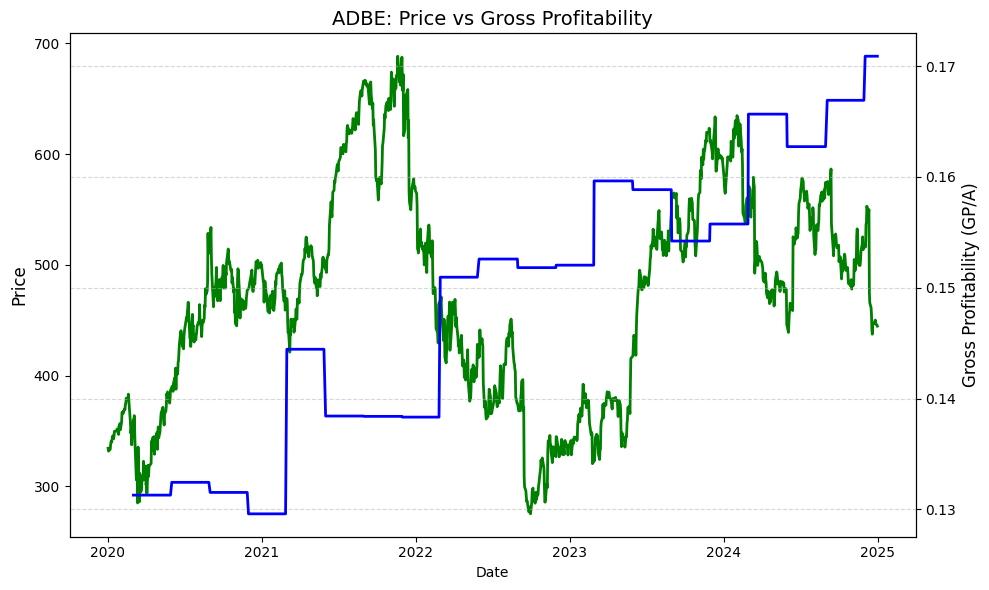

In [39]:
plot_price_and_gp(ts, ticker_of_interest)